In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from torch.nn import functional as F
from source.network.ravepqmf import PQMF
from source.network.metrics import spectral_distance, multiscale_stft

def generate_white_noise(length, sr=44100):
    """Generate white noise as a numpy array."""
    noise = np.random.randn(length *  sr)
    return torch.from_numpy(noise).float().unsqueeze(0).unsqueeze(0)

def load_audio(file_path, sr=44100):
    """Load audio file and convert to torch tensor."""
    audio, _ = librosa.load(file_path, sr=sr)
    print(audio.shape)
    return torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0)

def plot_waveform(signal, title):
    """Plot waveform of the signal."""
    plt.figure(figsize=(12, 4))
    plt.plot(signal.squeeze().numpy())
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def plot_spectrogram(signal, sr, title):
    """Plot spectrogram of the signal."""
    D = librosa.stft(signal.squeeze().numpy())
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.yscale('log')
    plt.show()

def plot_frequency_domain(signal, sample_rate=44100, title=''):
    """Plot frequency domain representation of the signal."""
    fft = np.fft.fft(signal.squeeze().numpy())
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    plt.figure(figsize=(12, 4))
    plt.plot(np.abs(fft))
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xscale('log')
    plt.show()


def analyze_signal(signal, sr, title_prefix):
    """Analyze and plot signal in time, frequency, and spectrogram domains."""
    plot_waveform(signal, f"{title_prefix} (Time Domain)")
    plot_frequency_domain(signal, sr, f"{title_prefix} (Frequency Domain)")
    plot_spectrogram(signal, sr, f"{title_prefix} (Spectrogram)")

In [22]:
# Load and analyze original signal
print("Part 1: PQMF Decomposition and Reconstruction")
sr=44100 
signal = generate_white_noise(5, sr) 
title_prefix="Original Signal"

Part 1: PQMF Decomposition and Reconstruction


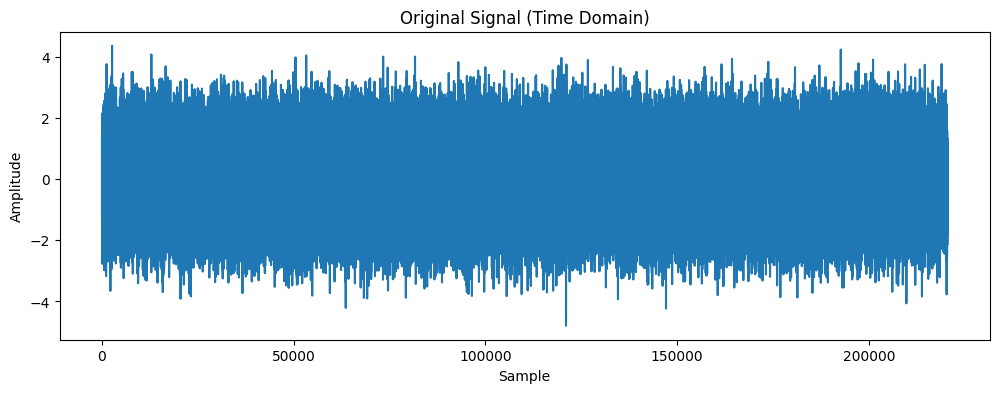

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(signal.squeeze().numpy())
plt.title(f"{title_prefix} (Time Domain)")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

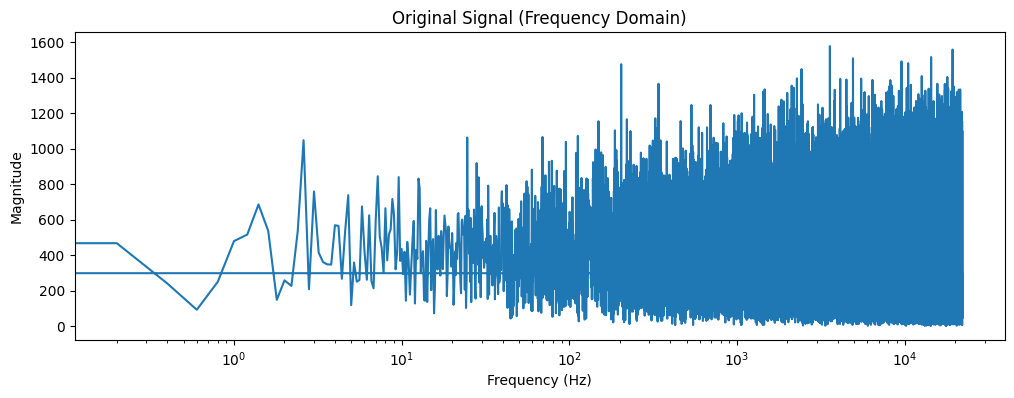

In [24]:
fft = np.fft.fft(signal.squeeze().numpy())
freqs = np.fft.fftfreq(len(fft), 1/sr)
plt.figure(figsize=(12, 4))
plt.plot(freqs, np.abs(fft))
plt.title(f"{title_prefix} (Frequency Domain)")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.show()

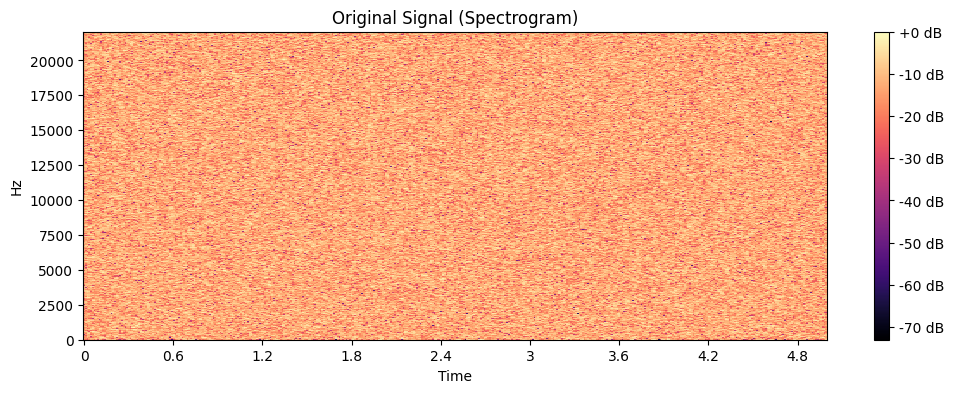

In [25]:
D = librosa.stft(signal.squeeze().numpy())
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"{title_prefix} (Spectrogram)")
plt.show()

In [26]:
def decompose_and_reconstruct(signal, pqmf):
    """Decompose signal using PQMF and reconstruct it."""
    pad_length = (4 - (signal.shape[-1] % 4)) % 4
    padded_signal = F.pad(signal, (0, pad_length))
    decomposed = pqmf.forward(padded_signal)
    reconstructed = pqmf.inverse(decomposed)
    return decomposed, reconstructed

Original signal shape: torch.Size([1, 1, 220500])
Decomposed signal shape: torch.Size([1, 4, 55125])


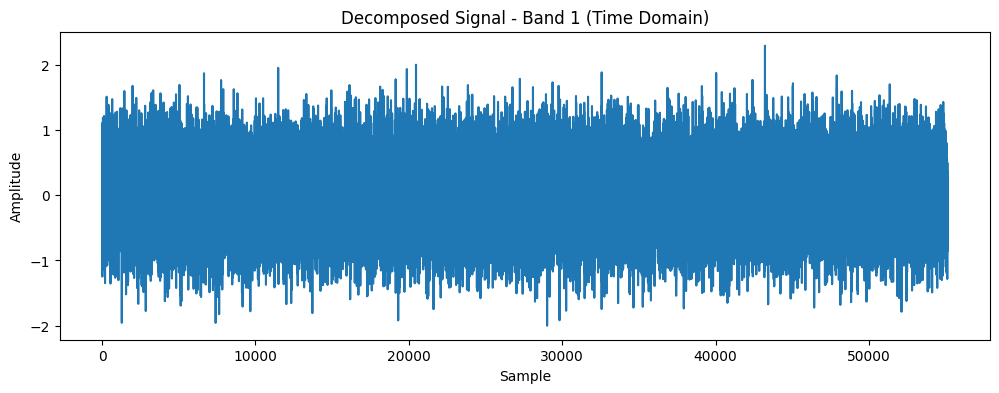

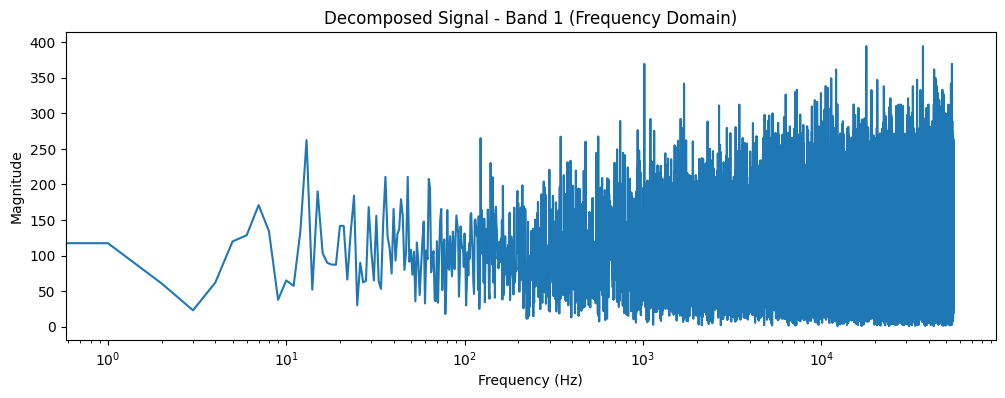

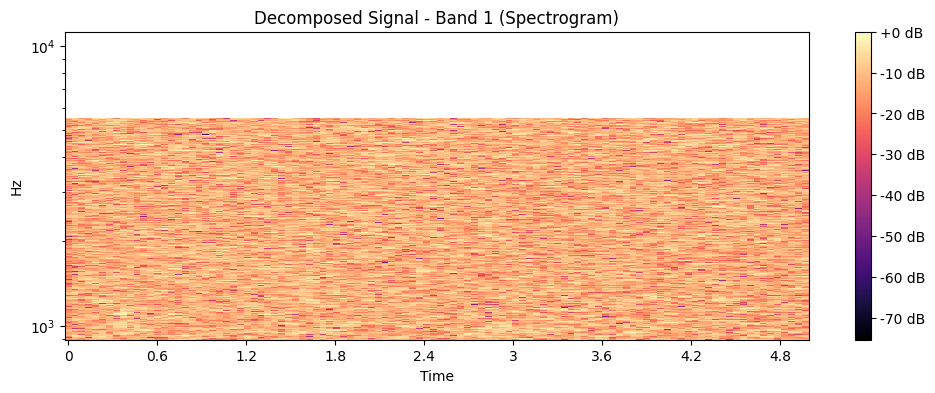

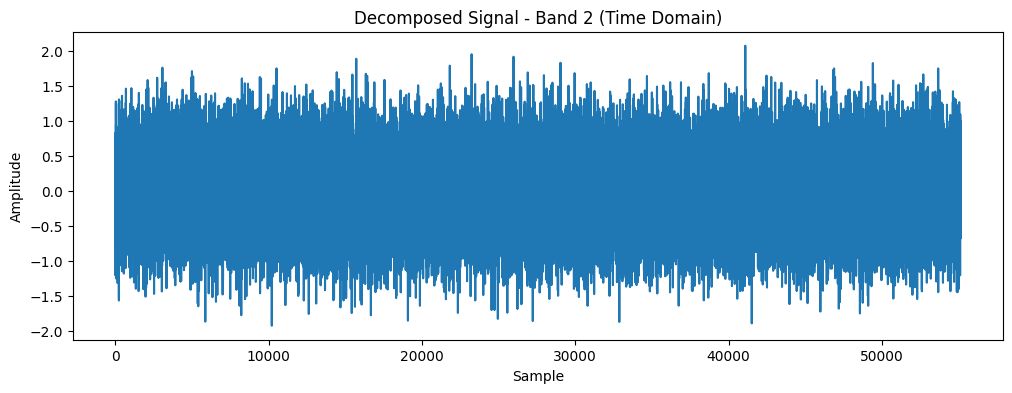

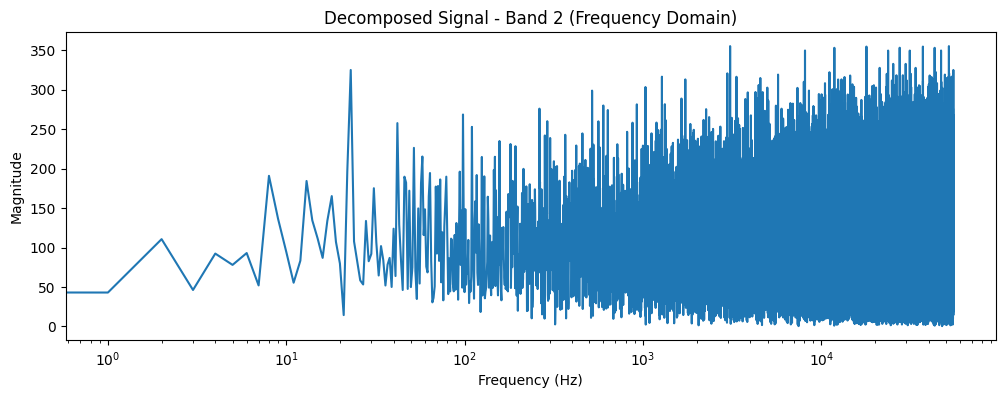

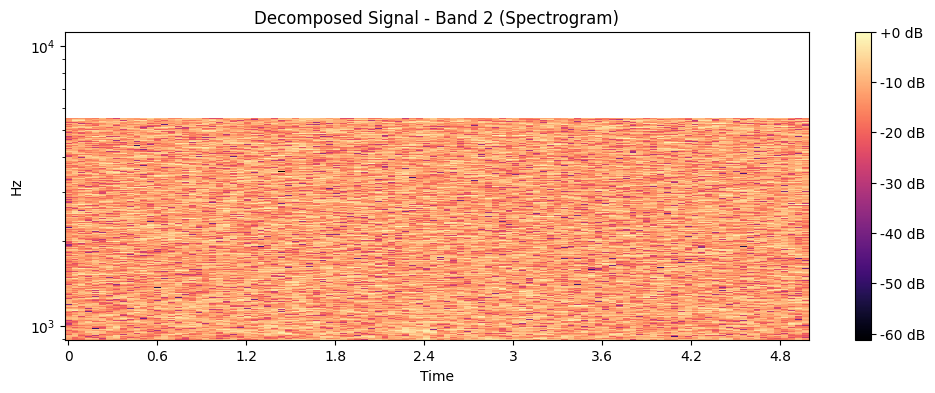

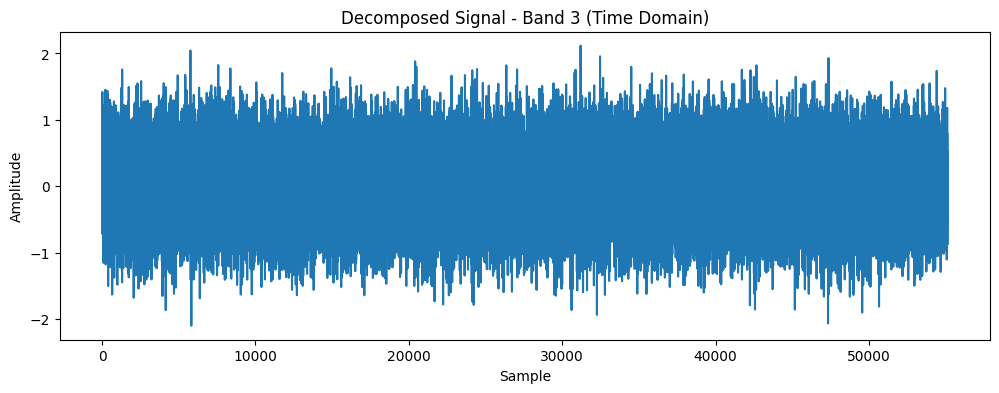

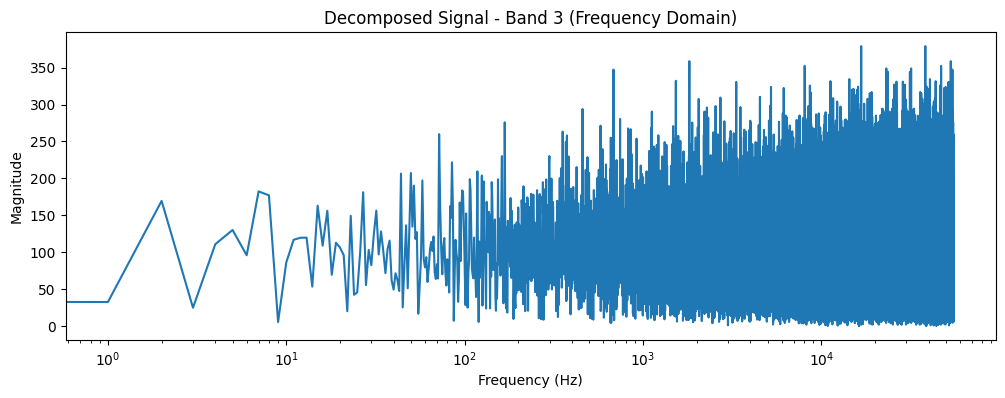

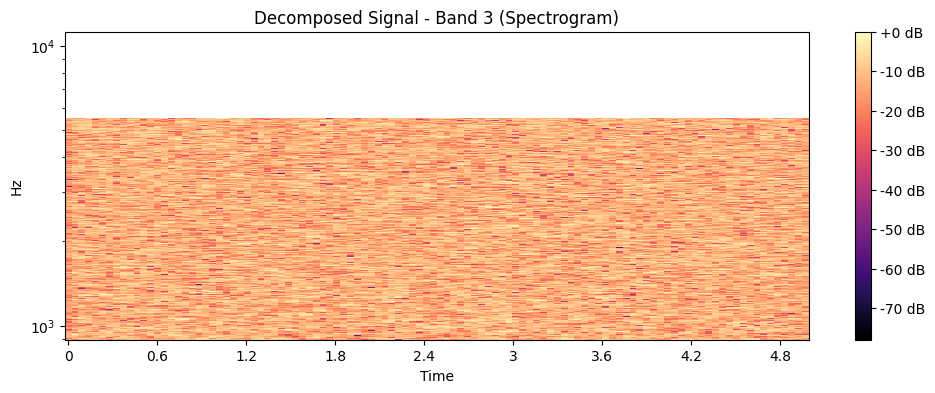

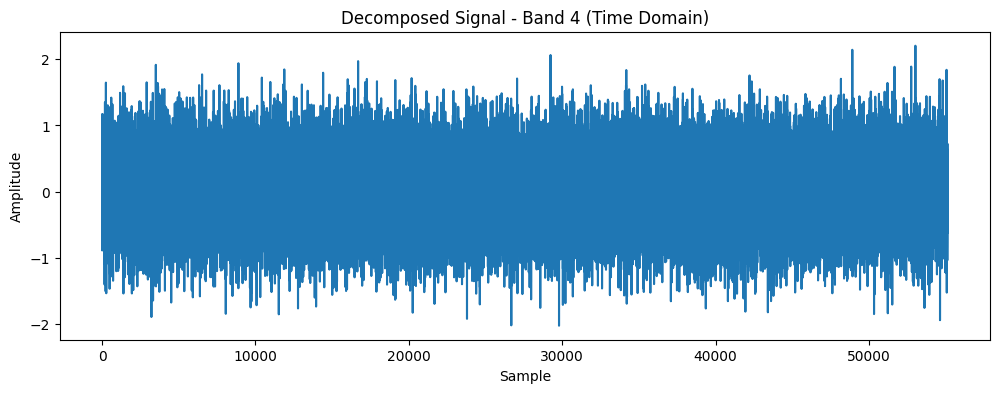

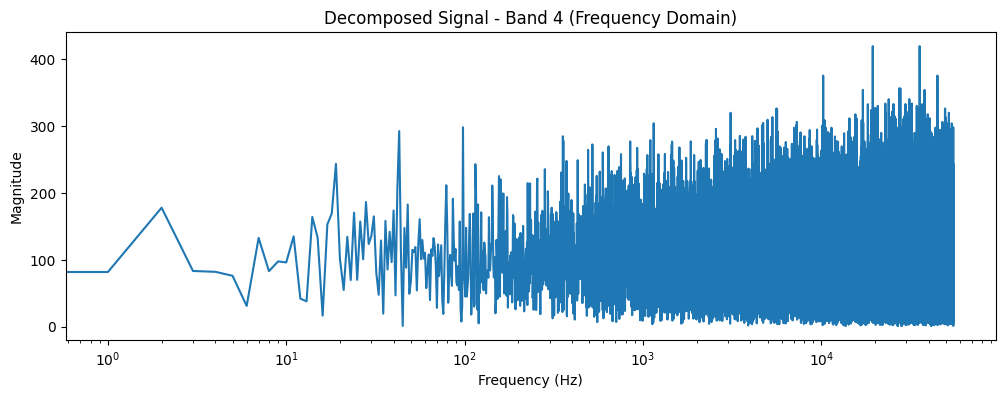

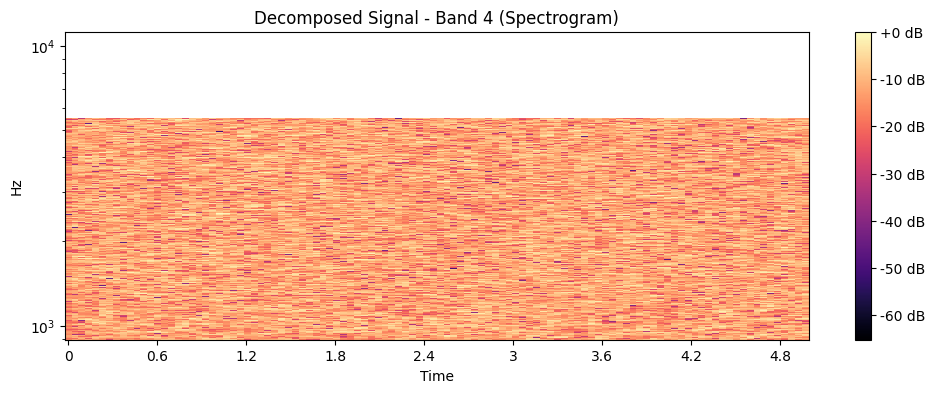

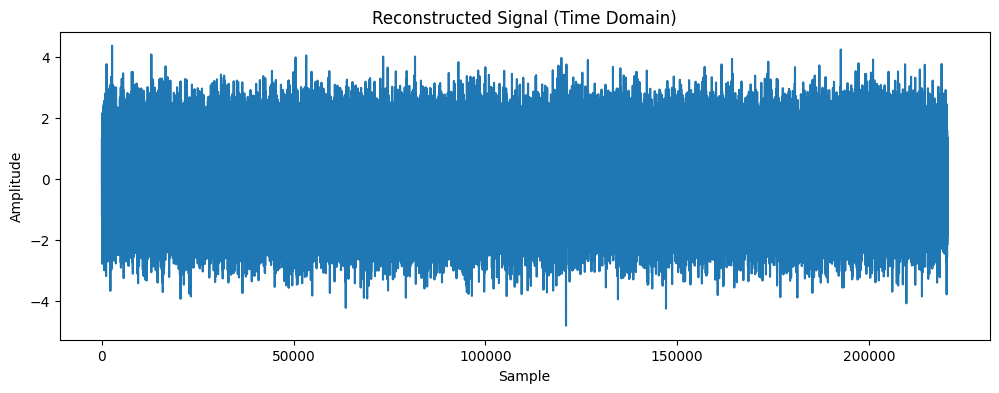

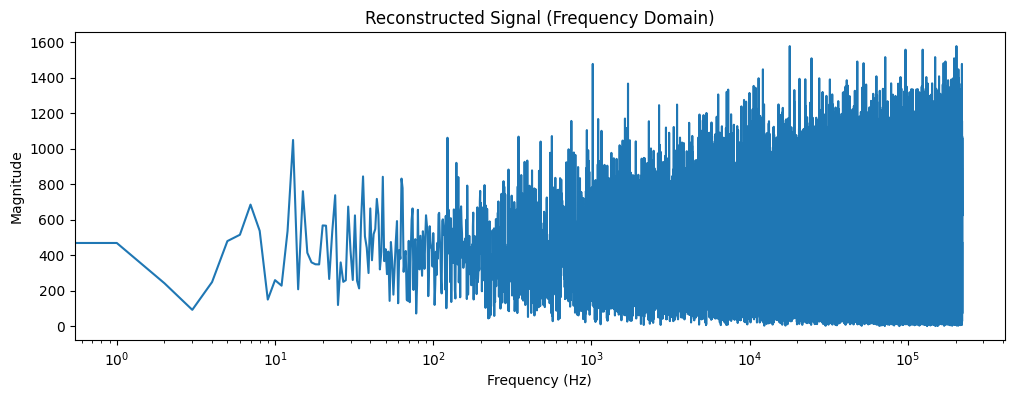

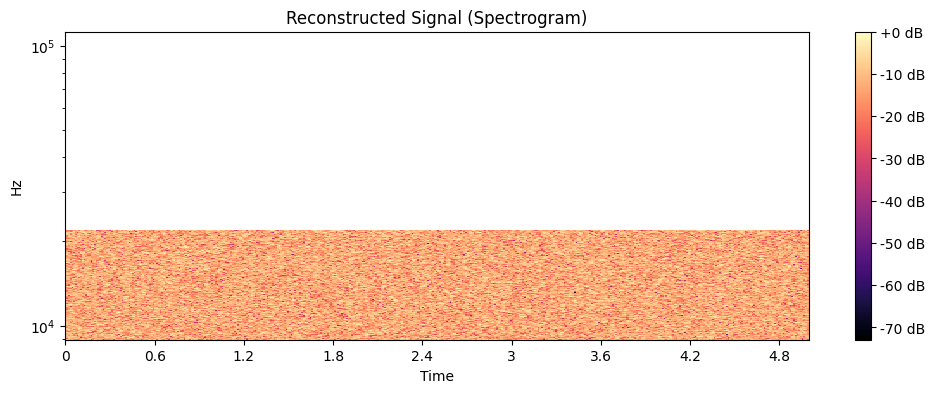

In [27]:
# Initialize PQMF
pqmf = PQMF(attenuation=80, n_band=4)

# Decompose and reconstruct signal
decomposed, reconstructed = decompose_and_reconstruct(signal, pqmf)
print(f"Original signal shape: {signal.shape}")
print(f"Decomposed signal shape: {decomposed.shape}")

# Play decomposed audio
for i in range(decomposed.shape[1]):
    audio_data = decomposed[0, i, :].cpu().numpy()
    display(Audio(audio_data, rate=int(44100/4)))

# Analyze decomposed signals
for i in range(decomposed.shape[1]):
    band_signal = decomposed[0, i, :]
    analyze_signal(band_signal, sr=int(44100/4), title_prefix=f"Decomposed Signal - Band {i+1}")

# Analyze reconstructed signal
analyze_signal(reconstructed, sr=44100, title_prefix="Reconstructed Signal")

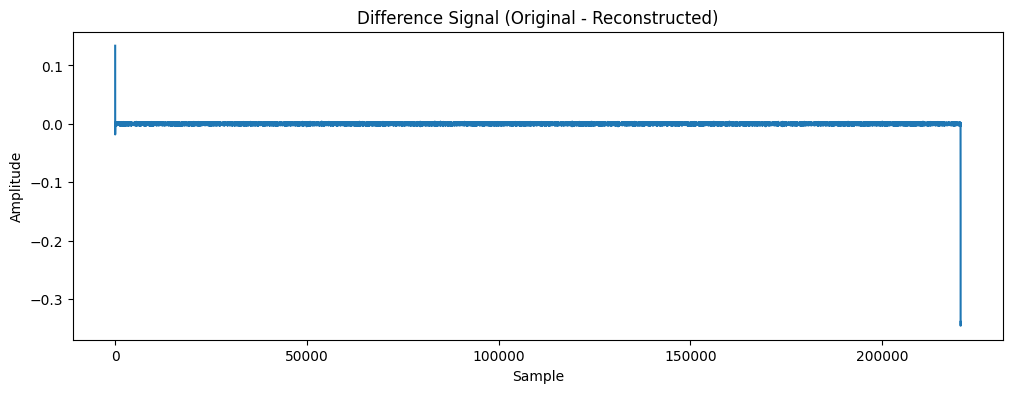

In [28]:
def plot_difference_signal(original, reconstructed, title='Difference Signal (Original - Reconstructed)'):
    """Plot the difference between the original and reconstructed signals."""
    difference = original.squeeze().numpy() - reconstructed.squeeze().numpy()
    plt.figure(figsize=(12, 4))
    plt.plot(difference)
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

pad_length = (4 - (signal.shape[-1] % 4)) % 4
padded_signal = F.pad(signal, (0, pad_length))

# Example usage:
plot_difference_signal(padded_signal, reconstructed)


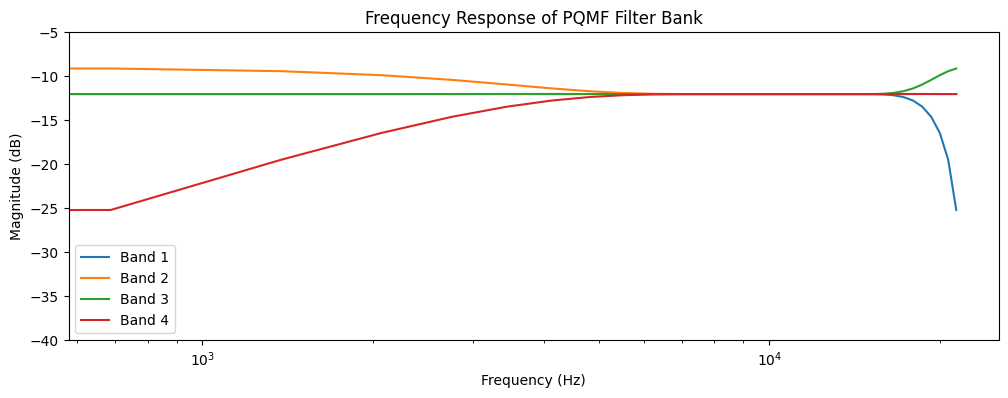

In [29]:
def plot_frequency_response(pqmf, sr=44100, title='Frequency Response of PQMF Filter Bank'):
    """Plot the frequency response of the PQMF filter bank."""
    impulse = torch.zeros((1, 1, 256))
    impulse[0, 0, 128] = 1.0
    response = pqmf.forward(impulse).squeeze().numpy()
    
    plt.figure(figsize=(12, 4))
    for i in range(response.shape[0]):
        fft = np.fft.fft(response[i, :])
        freqs = np.fft.fftfreq(len(fft), 1/sr)
        plt.plot(freqs[:len(freqs)//2], 20 * np.log10(np.abs(fft[:len(freqs)//2])), label=f'Band {i+1}')
    plt.title(title)
    plt.xscale('log')
    plt.ylim(-40, -5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.legend()
    plt.show()

# Example usage:
plot_frequency_response(pqmf)
